### Statistical description of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from brainconn.centrality import participation_coef
from brainconn.modularity import modularity_louvain_dir, modularity_louvain_und
from frites.conn.conn_tf import _create_kernel, _smooth_spectra
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.stats import ks_2samp, mannwhitneyu, ttest_1samp
from statannot import add_stat_annotation
from tqdm import tqdm
from utils import *

from config import get_dates, return_evt_dt
from GDa.graphics import plot
from GDa.loader import loader
from GDa.stats.bursting import find_activation_sequences, find_start_end
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi
from GDa.flatmap.flatmap import flatmap

#### Auxiliar functions

In [3]:
import numba as nb


@nb.jit(nopython=True)
def _hamming(x, y):
    """
    Calculate the Hamming distance between two arrays.

    The Hamming distance is the number of positions at which the corresponding elements are different.

    Parameters:
    x (ndarray): first array
    y (ndarray): second array
    Returns:
    float: The Hamming distance as a proportion of the maximum possible Hamming distance.
    """
    # sum_and = np.logical_and(x, y).sum()
    max_sum = np.min([x.sum(), y.sum()])
    return sum_and / max_sum


@nb.jit(nopython=True)
def hamming(x, y):

    nroi, ntrials, ntimes = x.shape

    dists = np.zeros((nroi, ntrials))

    for i in range(ncols):
        dists[:, i] = _hamming(x[:, i, :], y[:, i, :])

    return dists


def return_consensus_vector(A, fmod=modularity_louvain_und, nruns=None, verbose=False):
    """
    Return the consensus vector for a given set of community assignments.

    This function takes a matrix of community assignments (A), a modularity function (fmod), and the number of runs (nruns)
    to return the consensus vector of the assignments. The consensus vector is calculated by averaging the affiliation vectors of each run.

    Parameters:
    A (ndarray or xr.DataArray): matrix of community assignments.
    fmod (callable): modularity function used to calculate community assignments. Default is louvain method.
    nruns (int): number of runs to calculate consensus vector over. Default is None.
    Returns:
    Tuple: (idx, q) where idx is the community assignments and q is the modularity score
    """
    nC = len(A)

    if isinstance(A, xr.DataArray):
        A = A.data

    # Creates consensus vector for different runs
    av = []
    for i in tqdm(range(nruns)) if verbose else range(nruns):
        idx, _ = fmod(A, seed=i * 1000)
        av += [idx]
    av = np.stack(av)

    def _for_frame(av):
        # Allegiance for a frame
        T = np.zeros((nC, nC))
        # Affiliation vector
        # For now convert affiliation vector to igraph format
        n_comm = int(av.max() + 1)
        for j in range(n_comm):
            p_lst = np.arange(nC, dtype=int)[av == j]
            grid = np.meshgrid(p_lst, p_lst)
            grid = np.reshape(grid, (2, len(p_lst) ** 2)).T
            T[grid[:, 0], grid[:, 1]] = 1
        np.fill_diagonal(T, 0)
        return T

    T = []
    for i in range(nruns):
        T += [_for_frame(av[i])]

    T = np.stack(T).mean(0)

    return modularity_louvain_und(T)


@nb.jit(nopython=True)
def co_crackling_adj(A):
    """
    Calculate the co-crackling matrix for a given matrix adjacency.

    Parameters:
    A (ndarray): matrix of community assignments where rows are rois and columns are time points
    Returns:
    ndarray: 3-D co-crackling matrix, where the last dimension corresponds to time point.
    """
    nroi, nobs = A.shape

    out = np.zeros((nroi, nroi, nobs))

    for T in range(nobs):
        idx = A[:, T]
        out[..., T] = np.outer(idx, idx)
        np.fill_diagonal(out[..., T], 0)

    return out


def plot_adj_modular(
    A, ci, offset=0.5, vmin=0, vmax=0.05, cmap="turbo", lw=5, color="k"
):
    """
    Plot a modular adjacency matrix with community boundaries.

    This function takes a adjacency matrix (A), a vector of community indices (ci), and optional arguments for
    plotting the matrix (offset, vmin, vmax, cmap, lw, color) and plots the adjacency matrix with lines denoting
    the boundaries between communities.

    Parameters:
    A (ndarray or xr.DataArray): adjacency matrix
    ci (ndarray): vector of community indices for each node in the adjacency matrix
    offset (float): offset for the community boundaries. Default is 0.5
    vmin (float): minimum value for color map. Default is 0
    vmax (float): maximum value for color map. Default is 0.05
    cmap (str): name of colormap to use. Default is 'turbo'
    lw (float): width of the lines used to draw the community boundaries. Default is 5
    color (str): color of the lines used to draw the community boundaries. Default is 'k'
    """
    _, c = np.unique(ci, return_counts=True)

    N = len(A)

    c = np.cumsum(c)
    c = np.hstack(([0], c))

    idx = np.argsort(ci)
    rois = A.sources.data[idx]

    if isinstance(A, xr.DataArray):
        plot_data = A.data[np.ix_(idx, idx)]
    else:
        plot_data = A[np.ix_(idx, idx)]
    plt.imshow(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, origin="lower")
    plt.xticks(range(N), rois, rotation=90)
    plt.yticks(range(N), rois)

    for i in range(1, len(c)):
        plt.hlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.vlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.hlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)
        plt.vlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)


def create_typeI_surr(A, seed=0, n_jobs=1, verbose=False):
    """
    create_typeI_surr - function to create type I surrogate data by shuffling the timepoints across trials for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrI (xarray.DataArray) - type I surrogate data with shuffled timepoints across trials for each ROI
    """

    nrois, nfreqs, ntrials, ntimes = A.shape
    dims, coords = A.dims, A.coords

    A = A.stack(obs=("trials", "times"))

    def _loop_rois(A_np):
        # Store surrogate
        A_surrI = A_np.copy()
        # Vector with trial indexes
        trials_idx = np.arange(0, ntimes * ntrials, 1, dtype=np.int8)
        # Loop over areas
        for i in range(nrois):
            idx_ = np.random.choice(trials_idx, ntimes * ntrials, replace=True)
            A_surrI[i, ...] = A_np[i, idx_]

        return A_surrI

    def _for_freq(f):
        np.random.seed(seed + f * 1000)
        return _loop_rois(A.data[:, f, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    A_surrI = parallel(p_fun(f) for f in range(nfreqs))
    A_surrI = np.stack(A_surrI, axis=1).reshape((nrois, nfreqs, ntrials, ntimes))
    A_surrI = xr.DataArray(A_surrI, dims=dims, coords=coords)

    return A_surrI.unstack()


def create_typeII_surr(A, seed=0, verbose=False, n_jobs=1):
    """
    create_typeII_surr - function to create type II surrogate data by shuffling the timepoints within each trial for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrII (xarray.DataArray) - type II surrogate data with shuffled timepoints within each trial for each ROI
    """

    nrois, nfreqs, ntrials, ntimes = A.shape
    dims, coords = A.dims, A.coords

    def _for_freq(f):

        np.random.seed(seed + f * 1000)

        A_surrII = A.data[:, f, :, :].copy()
        for i in range(nrois):
            for T in range(ntrials):
                idx_ = np.random.choice(range(ntimes), ntimes, replace=False)
                A_surrII[i, T, :] = A.data[i, f, T, idx_]

        return A_surrII

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    A_surrII = parallel(p_fun(f) for f in range(nfreqs))
    A_surrII = np.stack(A_surrII, axis=1).reshape((nrois, nfreqs, ntrials, ntimes))
    A_surrII = xr.DataArray(A_surrII, dims=dims, coords=coords)

    return A_surrII



def plot_brain_areas(ax, values, vmax=1):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas_dict = get_areas()

    area_no = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    areas = values.roi.data  # np.asarray([area for area in areas_dict.keys()])
    areas = [a.lower() for a in areas]
    fmap = flatmap(values.data, areas)

    fmap.plot(
        ax,
        ax_colorbar=None,
        cbar_title=None,
        alpha=0.4,
        colormap="hot_r",
        colors=None,
        vmin=0,
        vmax=vmax,
    )

#### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [5]:
metric = "coh"
monkey = "lucy"

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [8]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [9]:
data_loader = loader(_ROOT=_ROOT)

In [10]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

## Coordination and encoding

In [11]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")

p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [12]:
def return_power(trial_type=1, behavioral_response=1):
    power = []
    for session in tqdm(sessions):

        kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

        temp = data_loader.load_power(
            **kw_loader, trial_type=trial_type, behavioral_response=behavioral_response, session=session
        )
        
        #temp = (temp - temp.mean("times")) / temp.std("times")

        temp_2 = []
        for ti, tf in stages:
            temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

        temp_2 = xr.concat(temp_2, "times")

        power += [temp_2]

    power = data_loader.apply_min_rois(power, 10).sel(roi=t_pow.roi)
    return power

In [13]:
power_task = return_power(1, 1)

100%|████████████████████████████████████████████████████████| 62/62 [00:26<00:00,  2.38it/s]


In [14]:
degree = []
for session in tqdm(sessions):
    degree += [xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            session,
            "session01",
            "network",
            "pec_degree_at_cue.nc",
        )
    )]
    
    
    degree_avg = []
    for ti, tf in stages:
        degree_avg += [degree[-1].sel(times=slice(ti, tf)).mean(("times", "trials"))]
    degree[-1] = xr.concat(degree_avg, "times")
    
dpec = xr.concat(degree, "roi").groupby("roi").mean("roi").sel(roi=t_pow.roi)

100%|████████████████████████████████████████████████████████| 62/62 [00:18<00:00,  3.40it/s]


In [15]:
degree = []
for session in tqdm(sessions):
    degree += [xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            session,
            "session01",
            "network",
            "coh_degree_at_cue.nc",
        )
    )]
    
    
    degree_avg = []
    for ti, tf in stages:
        degree_avg += [degree[-1].sel(times=slice(ti, tf)).mean(("times", "trials"))]
    degree[-1] = xr.concat(degree_avg, "times")
    
dcoh = xr.concat(degree, "roi").groupby("roi").mean("roi").sel(roi=t_pow.roi)

100%|████████████████████████████████████████████████████████| 62/62 [00:18<00:00,  3.42it/s]


### Power/Coordination vs. encoding

In [16]:
powers = []

for session in tqdm(sessions):
    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    temp = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    #temp = (temp - temp.mean("times")) / temp.std("times")

    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

    powers += [xr.concat(temp_2, "times")]

    #roi_inters = np.intersect1d(power.roi.data, t_pow.roi.data).astype(str)

    #plt.scatter(power.groupby("roi").mean("roi").sel(roi=roi_inters).sel(freqs=27, times=2),
    #            t_pow.sel(freqs=27, times=2, roi=roi_inters), "b")

100%|████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.39it/s]


In [17]:
degrees = []

for session in tqdm(sessions):
    degree = xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            session,
            "session01",
            "network",
            "coh_degree_at_cue.nc",
        )
    )
    
    degree_avg = []
    for ti, tf in stages:
        degree_avg += [degree.sel(times=slice(ti, tf)).mean(("times", "trials"))]
    degrees += [xr.concat(degree_avg, "times")]

    #roi_inters = np.intersect1d(degree.roi.data, t_pow.roi.data).astype(str)

    #plt.scatter(degree.groupby("roi").mean("roi").sel(roi=roi_inters).sel(freqs=27, times=2),
    #            t_pow.sel(freqs=27, times=2, roi=roi_inters), c="b")

100%|████████████████████████████████████████████████████████| 62/62 [00:18<00:00,  3.43it/s]


In [18]:
CC = np.zeros((len(degrees), 10, 5))

pos = 0

for degree in tqdm(degrees):
    
    roi_inters = np.intersect1d(degree.roi.data, t_pow.roi.data).astype(str)
    
    for f in range(10):
        for t in range(5):
            CC[pos, f, t] = np.corrcoef(degree.isel(freqs=f, times=t).groupby("roi").mean("roi").sel(roi=roi_inters), 
                                        t_pow.isel(freqs=f, times=t).sel(roi=roi_inters))[0, 1]
            
    pos = pos + 1

100%|████████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.72it/s]


In [19]:
CC = confidence_interval(CC, axis=0).squeeze()

    Estimating CI (cis=[95], axis=0, n_boots=200, skipna=True, random_state=None)


In [20]:
CCP = np.zeros((len(degrees), 10, 5))

pos = 0

for degree in tqdm(powers):
    
    roi_inters = np.intersect1d(degree.roi.data, t_pow.roi.data).astype(str)
    
    for f in range(10):
        for t in range(5):
            CCP[pos, f, t] = np.corrcoef(degree.isel(freqs=f, times=t).groupby("roi").mean("roi").sel(roi=roi_inters), 
                                        t_pow.isel(freqs=f, times=t).sel(roi=roi_inters))[0, 1]
            
    pos = pos + 1

100%|████████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.78it/s]


In [21]:
CCP = confidence_interval(CCP, axis=0).squeeze()

    Estimating CI (cis=[95], axis=0, n_boots=200, skipna=True, random_state=None)


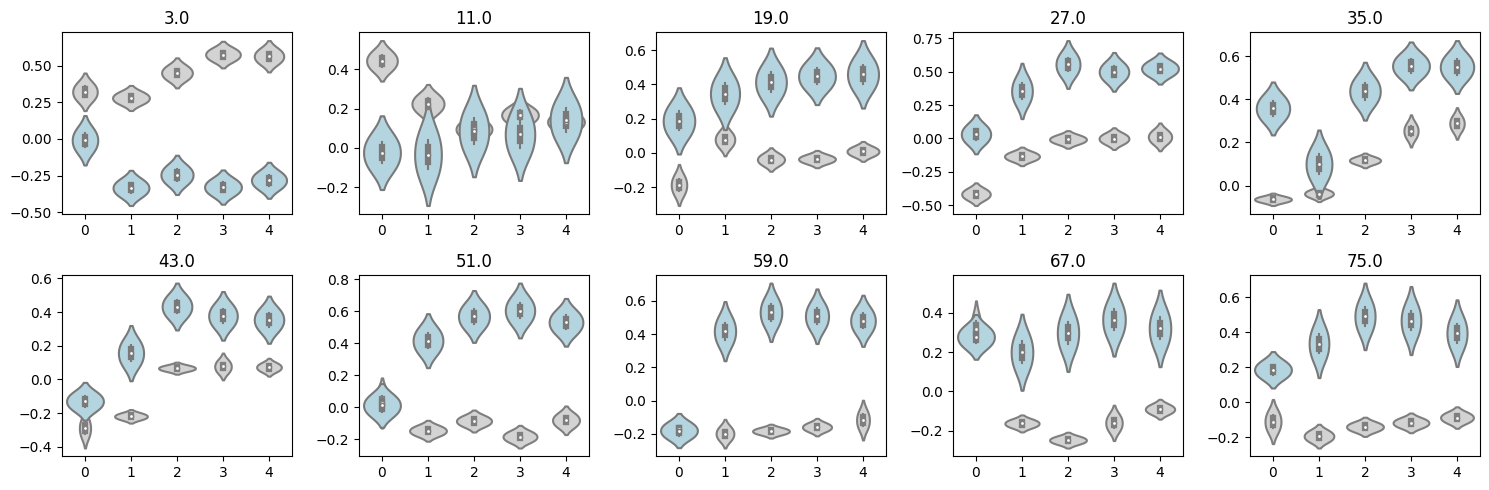

In [22]:
plt.figure(figsize=(15, 5))
pos = 1
for f in range(10):
    plt.subplot(2, 5, pos)
    sns.violinplot(data = CCP[:, f, :], color="lightgray")
    sns.violinplot(data = CC[:, f, :], color="lightblue")
    #plt.step(range(5), np.median(CCP[:, f, :], axis=0))
    #plt.fill_between(range(5), CCP[0, f, :], CCP[1, f, :], alpha=.3, step="pre")
    #plt.step(range(5), np.median(CC[:, f, :], axis=0))
    #plt.fill_between(range(5), CC[0, f, :], CC[1, f, :], alpha=.3, step="pre")
    pos = pos + 1
    plt.title(f"{power_task.freqs.data[f]}")
    
plt.tight_layout()

### Temporal Graph analysis

In [23]:
kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

power = data_loader.load_power(
    **kw_loader, trial_type=1, behavioral_response=1, session="141024"
).sel(freqs=27)


zpower = ((power - power.mean("times")) / power.std("times")).sel(times=slice(-.5, 2))

In [24]:
kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

power = data_loader.load_power(
    **kw_loader, trial_type=2, behavioral_response=0, session="141024"
).sel(freqs=27)


zpowerfix = ((power - power.mean("times")) / power.std("times")).sel(times=slice(-.5, 2))

Text(0.5, 1.0, 'Fixation')

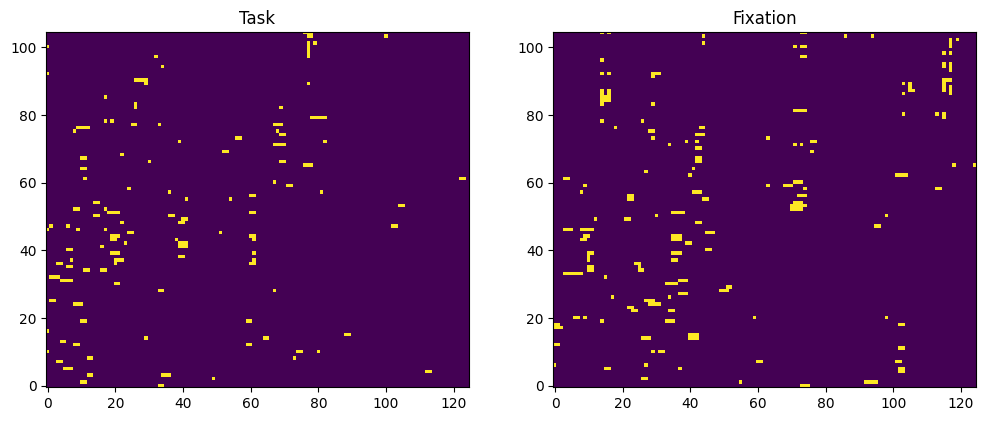

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(zpower.isel(trials=0) >= 3, origin="lower")
plt.title("Task")

plt.subplot(1, 2, 2)
plt.imshow(zpowerfix.isel(trials=0) >= 3, origin="lower")
plt.title("Fixation")

In [26]:
def convert_to_supra_adj(raster, verbose=False):
    """
    Convert a raster matrix to a supra-adjacency matrix.

    Parameters
    ----------
    raster : ndarray
        Input raster matrix.
    verbose : bool, optional
        If True, display progress using tqdm. Defaults to False.

    Returns
    -------
    ndarray
        Supra-adjacency matrix.

    """
    
    raster = raster.astype(int)
    nroi, ntimes = raster.shape
    
    supraA = np.zeros((nroi * ntimes, nroi * ntimes), dtype=int)
    
    __iter = range(ntimes - 1)
    
    #if verbose:
    #    __iter = tqdm(__iter)
    
    for t in __iter:
        raster_t = raster[:, t].data
        for x in range(nroi):
            for y in range(x + 1, nroi):
                cxx = raster_t[x] * raster_t[x]
                cyy = raster_t[y] * raster_t[y]
                cxy = raster_t[x] * raster_t[y]
                supraA[x + nroi * t, y + nroi * (t + 1)] = cxy
                supraA[y + nroi * t, x + nroi * (t + 1)] = cxy
                supraA[x + nroi * t, x + nroi * (t + 1)] = cxx
                supraA[y + nroi * t, y + nroi * (t + 1)] = cyy
                supraA[x + nroi * t, y + nroi * t] = cxy
                supraA[y + nroi * t, x + nroi * t] = cxy
                
    return supraA

In [27]:
supraA = convert_to_supra_adj(zpower.isel(trials=100) > 3, verbose=True)

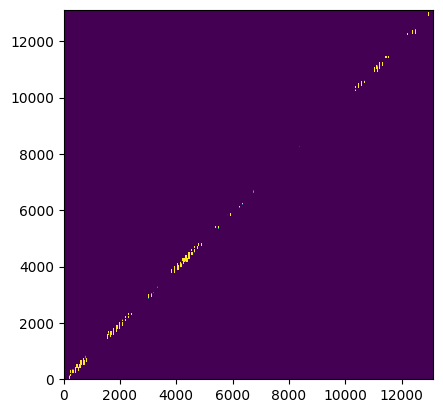

In [28]:
plt.imshow(supraA, vmax=1e-7, origin="lower")

In [29]:
import networkx as nx
import igraph as ig

In [30]:
troi = []
for t in range(zpower.sizes["times"]):
    troi += [f"{r}_{t}" for r in zpower.roi.data]
    
troi = np.hstack(troi)

In [31]:
def return_connected_components(raster, node_labels, min_size=1, verbose=False):
    """
    Return the connected components of a raster matrix.

    Args:
        raster (ndarray): Input raster matrix.
        node_labels (list): List of node labels.
        min_size (int, optional): Minimum size of connected components to consider. Defaults to 1.
        verbose (bool, optional): If True, display progress using tqdm. Defaults to False.

    Returns:
        list: List of connected components.

    Raises:
        None
    """
    
    supraA = convert_to_supra_adj(raster, verbose=True)
    
    # Convert to networkx graph
    G = nx.from_numpy_array(supraA)
    # Decompose graph
    dG = ig.Graph.from_networkx(G).components(mode="strong")
    # Number of connected components
    ncomp = len(dG)
    # Size of components
    sizes = np.array(dG.sizes())
    # Bigger than min_size components
    idx = np.where(np.array(dG.sizes()) > min_size)[0]
    # Components 
    dG = list(dG)
    
    def _for_component(i):
        
        return node_labels[dG[i]]
    
    __iter = tqdm(idx) if verbose else idx
    
    return [_for_component(i) for i in __iter]


def parallel_wrapper(raster, node_labels, min_size=1, n_jobs=1, verbose=False):
    
    ntrials = raster.sizes["trials"]
    

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        return_connected_components, n_jobs=n_jobs, verbose=verbose,
        total=ntrials)
    
    # Compute the single trial coherence
    out = parallel(p_fun(raster[:, T, :], node_labels, min_size, False) for T in range(ntrials))
    
    return out

In [32]:
avalanches = parallel_wrapper(zpower >= 3, troi, 1, 20, False)

  0%|          |  : 0/582 [00:00<?,       ?it/s]

In [33]:
avalanches_fix = parallel_wrapper(zpowerfix >= 3, troi, 1, 20, False)

  0%|          |  : 0/84 [00:00<?,       ?it/s]

In [36]:
def get_areas_times(avalanches):
    """
    Extract the areas and times from a list of avalanches.

    Args:
        avalanches (list): List of avalanches.

    Returns:
        tuple: Two lists containing the extracted areas and times, respectively.

    Raises:
        None
    """
    areas = []
    times = []
    for avalanche in avalanches:
        for av in avalanche:
            t, a = _extract_roi(av, "_")
            times += [t]
            areas += [a]
            
    return areas, times

def get_area_mapping(unique_areas):
    area2idx = dict( zip(unique_areas, range(len(unique_areas))) )
    return area2idx

def get_coavalanche_matrix(areas, times):
    """
    Calculate the coavalanche matrix, precedence matrix, and delta values.

    Args:
        areas (list): List of areas.
        times (list): List of times.

    Returns:
        tuple: A tuple containing the coavalanche matrix, precedence matrix, and delta values.

    Raises:
        None
    """
    
    navalanches = len(areas)

    unique_areas = np.unique(np.hstack(areas))
    n_unique_areas = len(unique_areas)
    area2idx = get_area_mapping(unique_areas)
    
    T = np.zeros((n_unique_areas, n_unique_areas))
    P = np.zeros((n_unique_areas, n_unique_areas))
    
    delta = np.zeros(navalanches)

    for i in tqdm(range(navalanches)):
        ua = np.unique(areas[i])
        # Index of areas in the avalanche
        idx = [area2idx[area] for area in ua]
        # Time slice of each area
        tava = times[i].astype(int)
        # Avalanche duration
        delta[i] = tava.max() - tava.min()
        # Coactivation
        T[np.ix_(idx, idx)] += 1
        # Precedence
        min_times = []
        for a in ua:
            min_times += [times[i].astype(int)[areas[i] == a].min()]
        min_times = np.array(min_times)
        prec = np.array(min_times)[:, None] < np.array(min_times)
        P[np.ix_(idx, idx)] += prec.astype(int)
        
        
    np.fill_diagonal(T, 0)

    T = xr.DataArray(T / navalanches,
                     dims=("sources", "targets"),
                     coords=(unique_areas, unique_areas)
                     )
    P = xr.DataArray(P / navalanches,
                     dims=("sources", "targets"),
                     coords=(unique_areas, unique_areas)
                     )

    
    return T, P, delta


In [37]:
areas, times = get_areas_times(avalanches)
areasf, timesf = get_areas_times(avalanches_fix)

In [38]:
unique_areas = np.unique(np.hstack(areas))

In [39]:
n_unique_areas = len(unique_areas)

In [40]:
area2idx = dict( zip(unique_areas, range(len(unique_areas))) )

In [41]:
T, P, delta = get_coavalanche_matrix(areas, times)

100%|███████████████████████████████████████████████| 19475/19475 [00:01<00:00, 11532.48it/s]


In [42]:
Tf, Pf, deltaf = get_coavalanche_matrix(areasf, timesf)

100%|█████████████████████████████████████████████████| 2931/2931 [00:00<00:00, 12775.21it/s]


In [43]:
from brainconn.modularity import modularity_louvain_und

In [44]:
ci, _ = modularity_louvain_und(T.data)

In [45]:
ici = np.argsort(ci)

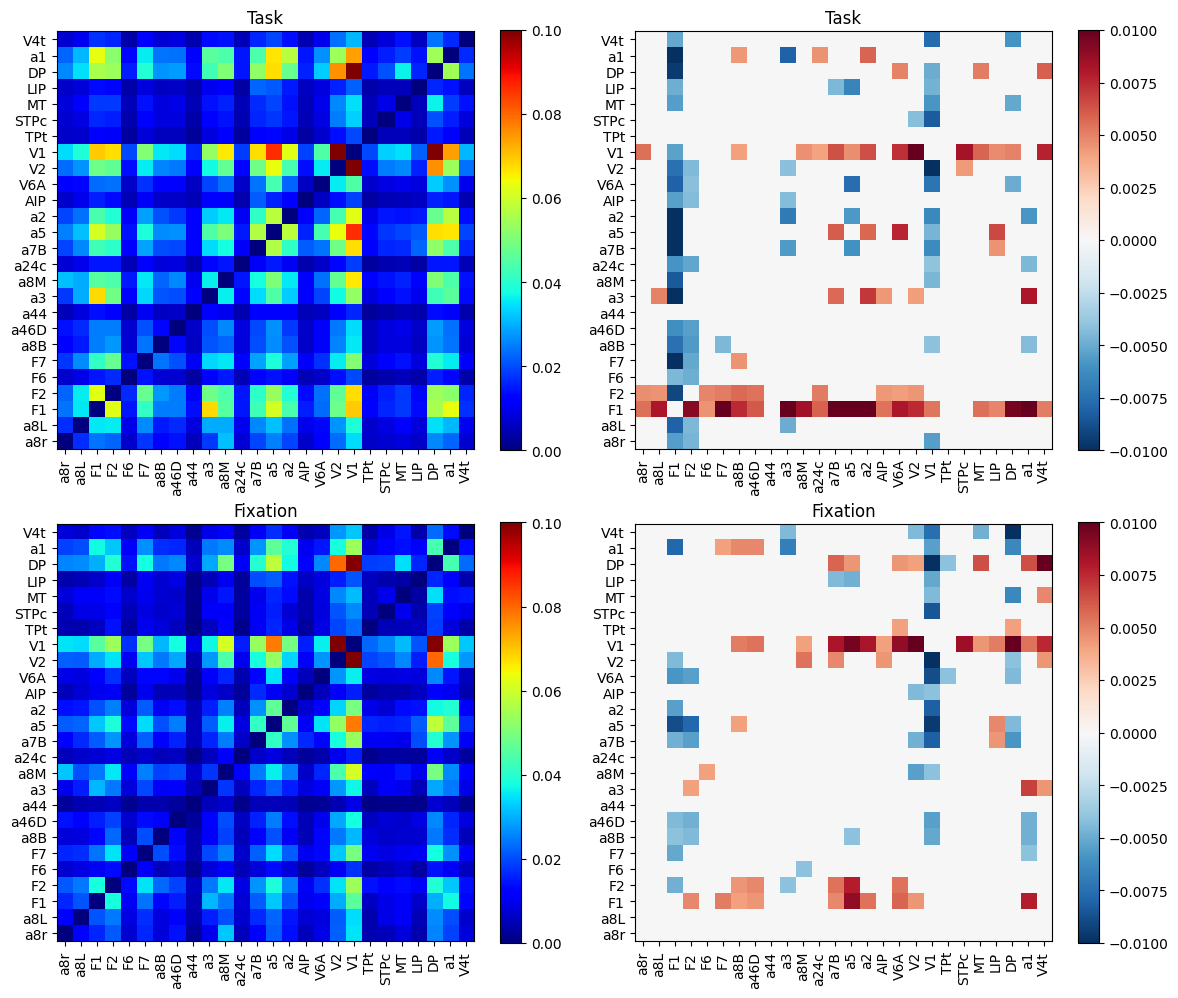

In [46]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(T.data[np.ix_(ici, ici)], origin="lower", vmin = 0, vmax=.1, cmap="jet")
plt.colorbar()
plt.xticks(range(n_unique_areas), unique_areas[ici], rotation=90)
plt.yticks(range(n_unique_areas), unique_areas[ici]);
plt.title("Task")

plt.subplot(2, 2, 3)
plt.imshow(Tf.data[np.ix_(ici, ici)], origin="lower", vmin = 0, vmax=.1, cmap="jet")
plt.colorbar()
plt.xticks(range(n_unique_areas), unique_areas[ici], rotation=90)
plt.yticks(range(n_unique_areas), unique_areas[ici]);
plt.title("Fixation")

matP = P.data[np.ix_(ici, ici)] - P.data[np.ix_(ici, ici)].T

matP[np.logical_and(matP > -0.004, matP < 0.004)] = 0

plt.subplot(2, 2, 2)
plt.imshow(matP, origin="lower", vmin = -.01, vmax=.01, cmap="RdBu_r")
plt.colorbar()
plt.xticks(range(n_unique_areas), unique_areas[ici], rotation=90)
plt.yticks(range(n_unique_areas), unique_areas[ici]);
plt.title("Task")

matPf = Pf.data[np.ix_(ici, ici)] - Pf.data[np.ix_(ici, ici)].T
matPf[np.logical_and(matPf > -0.004, matPf < 0.004)] = 0


plt.subplot(2, 2, 4)
plt.imshow(matPf,
           origin="lower", vmin = -.01, vmax=.01, cmap="RdBu_r")
plt.colorbar()
plt.xticks(range(n_unique_areas), unique_areas[ici], rotation=90)
plt.yticks(range(n_unique_areas), unique_areas[ici]);
plt.title("Fixation")
plt.tight_layout()

In [47]:
T = xr.concat((T, Tf), dim=("task"))
T = T.assign_coords({"task": [1, 0]})

In [49]:
Tdiif = (T - Tf) / (Tf + 1e-5)

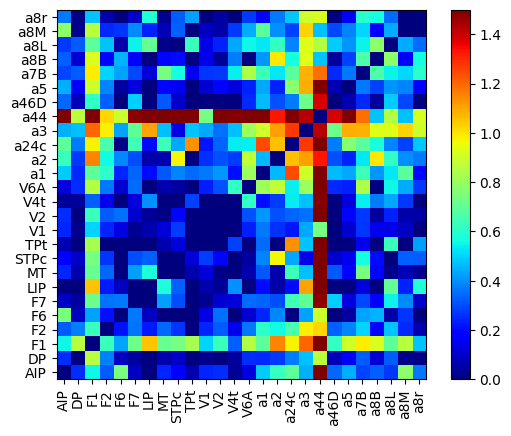

In [52]:
plt.imshow(Tdiif.isel(task=0).data, origin="lower", vmin = 0, vmax=1.5, cmap="jet")
plt.colorbar()
plt.xticks(range(n_unique_areas), unique_areas, rotation=90)
plt.yticks(range(n_unique_areas), unique_areas);

In [56]:
n, x = np.histogram(delta, 30);
n = n / np.sum(n * 1.13333333)
nf, xf = np.histogram(deltaf, 30);
nf = nf / np.sum(nf * 1.13333333)

/tmp/ipykernel_188225/3938778299.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x[1:], np.log(n), label='task')
/tmp/ipykernel_188225/3938778299.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(xf[1:], np.log(nf), label='fixation')


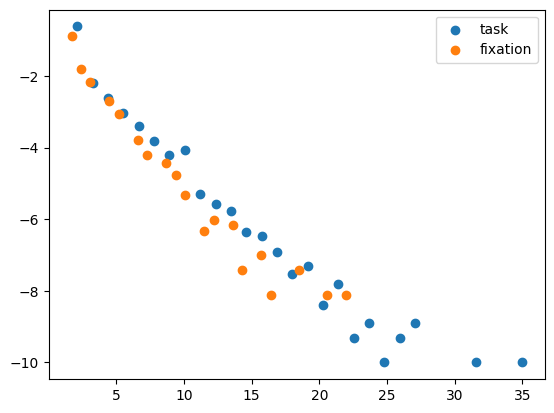

In [57]:
plt.scatter(x[1:], np.log(n), label='task')
plt.scatter(xf[1:], np.log(nf), label='fixation')
plt.legend()

In [59]:
G = []

nava = len(areas)

for n in tqdm(range(nava)):
    
    ua = np.unique(areas[n])
    
    # Normalize time from zero
    t = times[n].astype(int)
    t = t - t.min()
    
    av_raster = np.zeros((len(unique_areas), t.max() + 1))
    for i in np.unique(t):
        idx = [area2idx[area] for area in np.unique(areas[n][t == i])]
        av_raster[idx, i] = 1
        
    targets = []
    for i in range(t.max()):
        targets += [np.logical_and(~np.logical_and(av_raster[:, i], av_raster[:, i + 1]), av_raster[:, i + 1])]
    
    g = []
    for i in range(av_raster.shape[1] - 1):
        g += [np.outer(av_raster[:, i], targets[i])]
    
    G += [np.stack(g)]

100%|████████████████████████████████████████████████| 19475/19475 [00:02<00:00, 8531.09it/s]


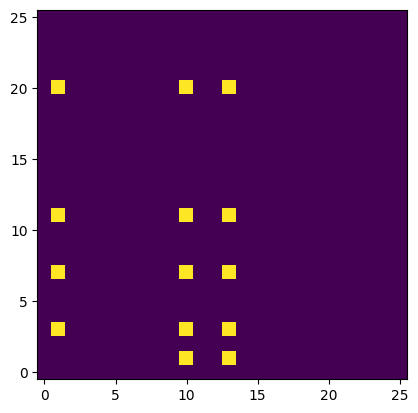

In [60]:
plt.imshow(G[20].sum(axis=0), origin="lower")

In [65]:
g = ig.Graph.Adjacency(G[20].sum(axis=0))

In [66]:
nx.write_gexf(g.to_networkx(), "graph.gexf")

### All sessions

In [91]:
from brainconn.degree import strengths_dir
from brainconn.centrality import betweenness_wei

In [69]:
_path_to_ava = os.path.expanduser("~/funcog/gda/Results/lucy/avalanches/")

In [70]:
dava = []

for session in tqdm(sessions):
    path = os.path.join(_path_to_ava, f"T_{session}_thr_3.nc")
    T = xr.load_dataarray(path)
    
    dava += [T.sum("targets")]

100%|███████████████████████████████████████████████████████| 62/62 [00:00<00:00, 221.43it/s]


In [71]:
dava = xr.concat(dava, "sessions")

In [72]:
CC = np.zeros((len(sessions), 5))
pos = 0
for session in tqdm(sessions):
    for t in range(5):
        x = dava.sel(sources=t_pow.roi, task=1).isel(sessions=pos)
        
        idx = ~np.isnan(x)
        x = x.isel(roi=idx)
        y = t_pow.sel(freqs=27, times=t).isel(roi=idx)
        CC[pos, t] = np.corrcoef(x, y)[0, 1]
    pos = pos + 1

100%|████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 60.52it/s]


Text(0.5, 1.0, 'Distribution across sessions 27 Hz')

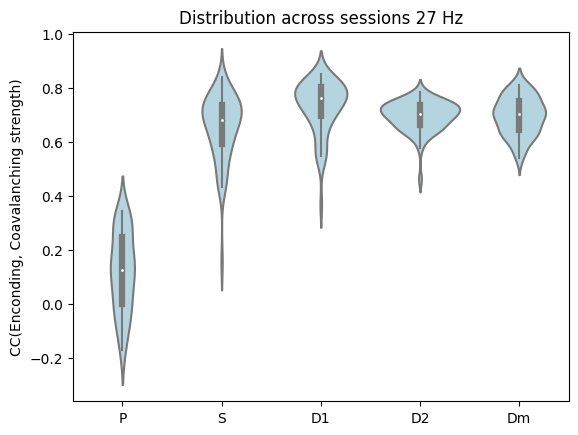

In [73]:
sns.violinplot(CC, color="lightblue", trim=True)
plt.xticks(range(5), stage_labels);
plt.ylabel("CC(Enconding, Coavalanching strength)")
plt.title("Distribution across sessions 27 Hz")

In [74]:
CCd = np.zeros((len(sessions), 5))
pos = 0
for session in tqdm(sessions):
    for t in range(5):
        x = dava.sel(sources=t_pow.roi, task=1).isel(sessions=pos)
        
        idx = ~np.isnan(x)
        x = x.isel(roi=idx)
        y = dcoh.sel(freqs=27, times=t).isel(roi=idx)
        CCd[pos, t] = np.corrcoef(x, y)[0, 1]
    pos = pos + 1

100%|████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 60.85it/s]


Text(0.5, 1.0, 'Distribution across sessions 27 Hz')

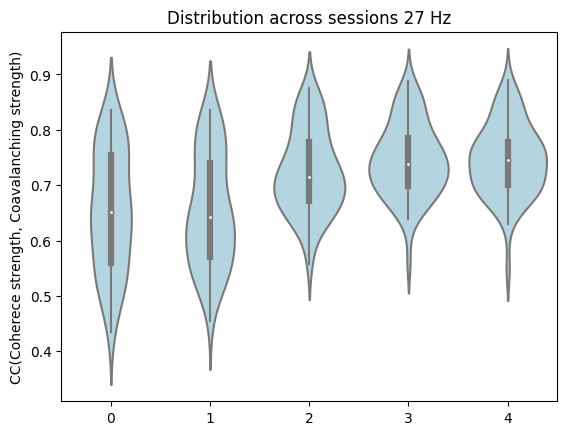

In [75]:
sns.violinplot(CCd, color="lightblue", trim=True)
plt.ylabel("CC(Coherece strength, Coavalanching strength)")
plt.title("Distribution across sessions 27 Hz")

100%|████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 57.37it/s]


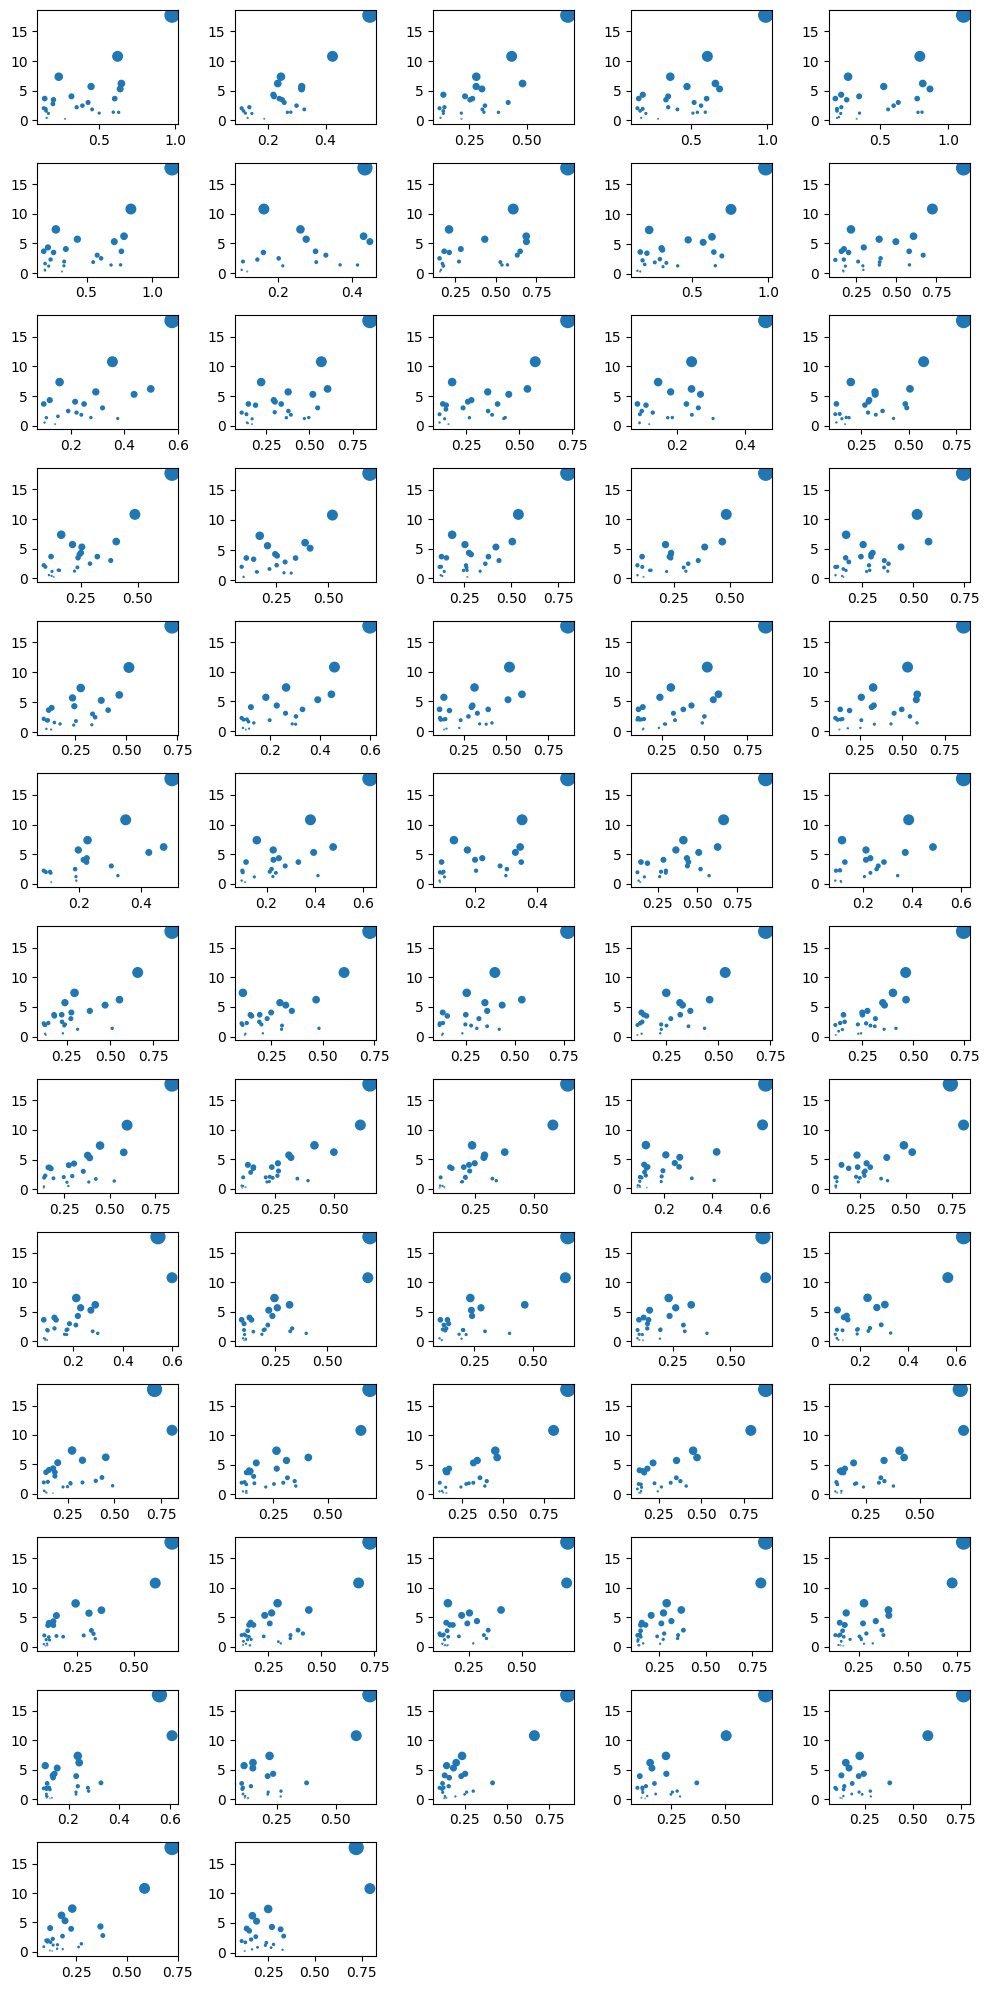

In [76]:
t = 2
pos = 0
plt.figure(figsize=(10, 20))
for session in tqdm(sessions):
    x = dava.sel(sources=t_pow.roi, task=1).isel(sessions=pos)
    idx = ~np.isnan(x)
    x = x.isel(roi=idx)
    y = t_pow.sel(freqs=27, times=t).isel(roi=idx)
    z = t_pow.sel(freqs=27, times=t).isel(roi=idx)
    z = (z / t_pow.sel(freqs=27).max()) ** 1.5
    plt.subplot(13, 5, pos + 1)
    plt.scatter(x, y, s=z * 100)
    pos = pos + 1
plt.tight_layout()

In [83]:
def return_propagation_scaffold(areas, times):
    
    
    unique_areas = np.unique(np.hstack(areas))
    area2idx = get_area_mapping(unique_areas)
    
    nava = len(areas)
    
    G = []
    for n in range(nava):
        ua = np.unique(areas[n])

        # Normalize time from zero
        t = times[n].astype(int)
        t = t - t.min()

        av_raster = np.zeros((len(unique_areas), t.max() + 1))
        for i in np.unique(t):
            idx = [area2idx[area] for area in np.unique(areas[n][t == i])]
            av_raster[idx, i] = 1

        targets = []
        for i in range(t.max()):
            targets += [np.logical_and(~np.logical_and(av_raster[:, i], av_raster[:, i + 1]), av_raster[:, i + 1])]

        g = []
        for i in range(av_raster.shape[1] - 1):
            g += [np.outer(av_raster[:, i], targets[i])]

        G += [np.stack(g)]
        
    G = np.concatenate(G, axis=0)
    
    return G

In [100]:
import pickle

betweenness = []
outStrength = []
inStrength = []

for session in tqdm(sessions):
    
    # Load node region label
    fname = os.path.join(_path_to_ava, f"areas_task_{session}_thr_3.pkl")
    with open(fname, 'rb') as f:
        areas = pickle.load(f)
        
    # Load node time label
    fname = os.path.join(_path_to_ava, f"times_task_{session}_thr_3.pkl")
    with open(fname, 'rb') as f:
        times = pickle.load(f)
        
    G = return_propagation_scaffold(areas, times).mean(0)
    
    ua = np.unique(np.hstack(areas))
    
    bet = betweenness_wei(G)
    inK, outK, K = strengths_dir(G)
    
    dims = ("roi")
    coords = {"roi": ua}
    
    bet = xr.DataArray(bet, dims=dims, coords=coords)
    inK = xr.DataArray(inK, dims=dims, coords=coords)
    outK = xr.DataArray(outK, dims=dims, coords=coords)
    
    betweenness += [bet]
    inStrength += [inK]
    outStrength += [outK]

100%|████████████████████████████████████████████████████████| 62/62 [02:03<00:00,  2.00s/it]


In [101]:
betweenness = xr.concat(betweenness,node_xr_remove_sca(inStrength.median(" "sessions")
inStrength = xr.concat(inStrength, "sessions")
outStrength = xr.concat(outStrength, "sessions")

In [122]:
ci_bet = confidence_interval(betweenness, axis=0, skipna=True, n_boots=1000).squeeze()

    Estimating CI (cis=[95], axis=0, n_boots=1000, skipna=True, random_state=None)
/home/vinicius/Documents/frites/frites/stats/stats_nonparam.py:282: RuntimeWarning: Mean of empty slice
  x_ci.append(fcn(x[tuple(sl)], axis=axis))


In [123]:
ci_bet = node_xr_remove_sca(ci_bet)

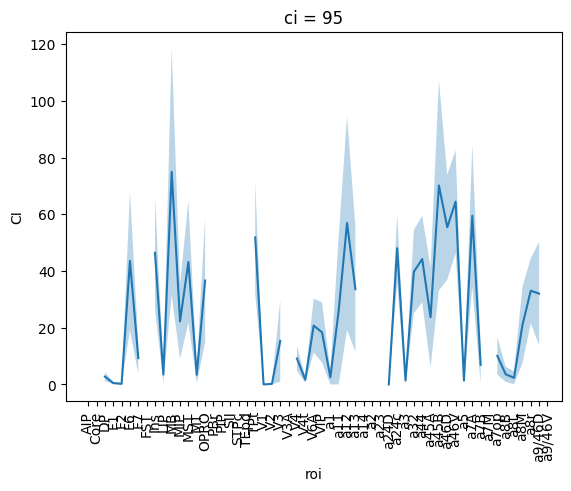

In [124]:
ci_bet.median("bound").plot()
plt.fill_between(range(ci_bet.sizes["roi"]), ci_bet[0], ci_bet[1], alpha=.3)

plt.xticks(rotation=90);

In [126]:
ci_ink = confidence_interval(inStrength, axis=0, skipna=True, n_boots=1000).squeeze()
ci_outk = confidence_interval(outStrength, axis=0, skipna=True, n_boots=1000).squeeze()

    Estimating CI (cis=[95], axis=0, n_boots=1000, skipna=True, random_state=None)
/home/vinicius/Documents/frites/frites/stats/stats_nonparam.py:282: RuntimeWarning: Mean of empty slice
  x_ci.append(fcn(x[tuple(sl)], axis=axis))
    Estimating CI (cis=[95], axis=0, n_boots=1000, skipna=True, random_state=None)
/home/vinicius/Documents/frites/frites/stats/stats_nonparam.py:282: RuntimeWarning: Mean of empty slice
  x_ci.append(fcn(x[tuple(sl)], axis=axis))


In [128]:
ci_ink = node_xr_remove_sca(ci_ink)
ci_outk = node_xr_remove_sca(ci_outk)

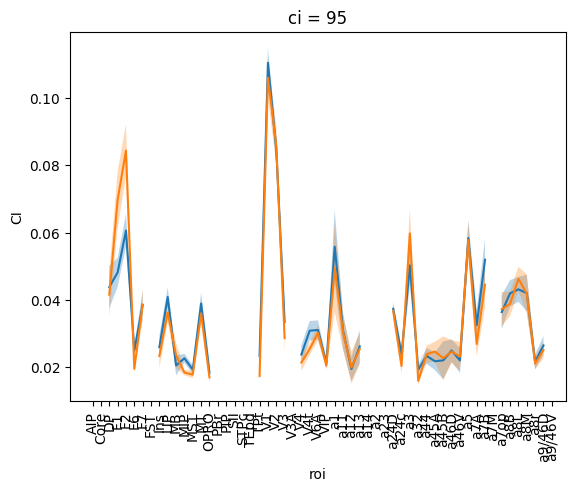

In [129]:
ci_ink.median("bound").plot()
plt.fill_between(range(ci_ink.sizes["roi"]), ci_ink[0], ci_ink[1], alpha=.3)

ci_outk.median("bound").plot()
plt.fill_between(range(ci_outk.sizes["roi"]), ci_outk[0], ci_outk[1], alpha=.3)

plt.xticks(rotation=90);

Text(0.5, 1.0, 'Out Strength')

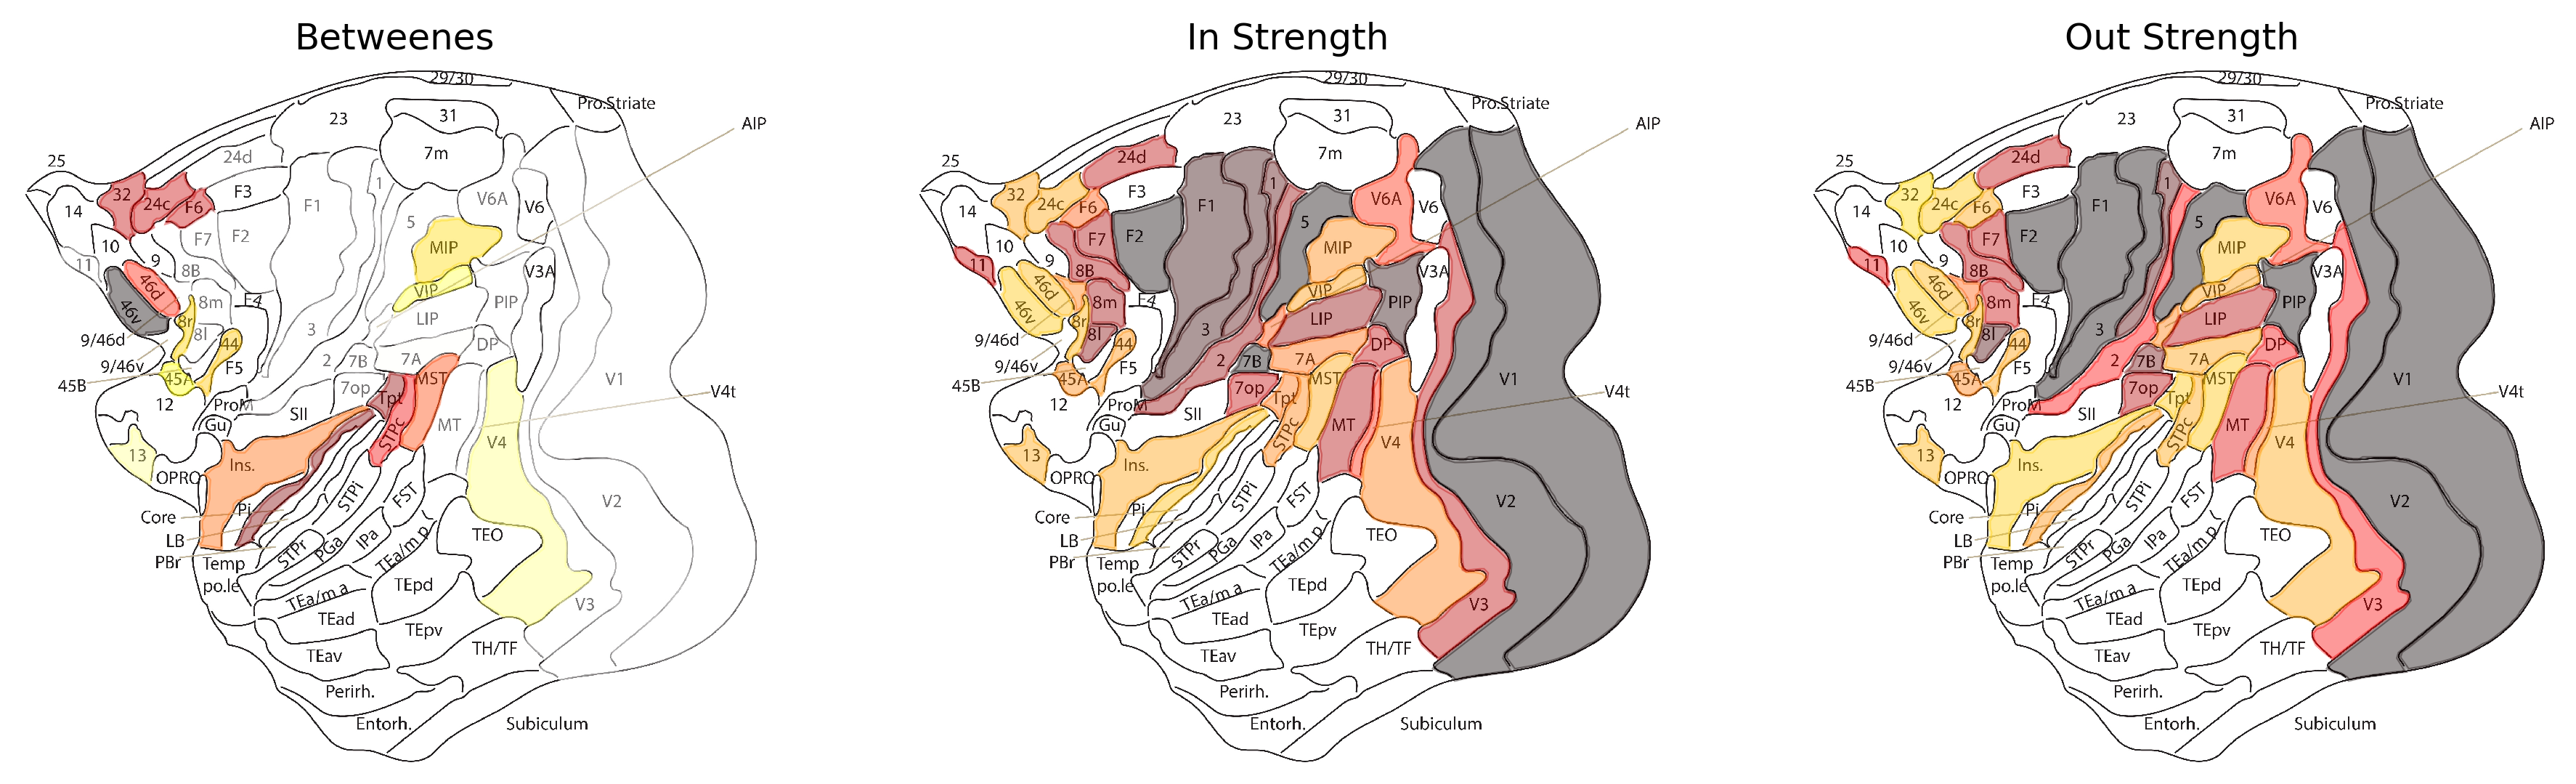

In [142]:
plt.figure(figsize=(15, 6), dpi=300)
ax = plt.subplot(131)
values = node_xr_remove_sca(betweenness.median("sessions").sel(roi=t_pow.roi))
plot_brain_areas(ax, values, vmax=50)
plt.title("Betweenes")

ax = plt.subplot(132)
values = node_xr_remove_sca(inStrength.median("sessions").sel(roi=t_pow.roi))
plot_brain_areas(ax, values, vmax=0.05)
plt.title("In Strength")


ax = plt.subplot(133)
values = node_xr_remove_sca(outStrength.median("sessions").sel(roi=t_pow.roi))
plot_brain_areas(ax, values, vmax=0.05)
plt.title("Out Strength")

In [172]:
areas

[array(['V4', 'V4'], dtype='<U2'),
 array(['V2', 'V2'], dtype='<U2'),
 array(['F1', 'F1'], dtype='<U2'),
 array(['V2', 'V2'], dtype='<U2'),
 array(['V2', 'V2'], dtype='<U2'),
 array(['a9/46D', 'a7op', 'a9/46D', 'a8B', 'a7op', 'Caudate', 'a9/46D',
        'a8B', 'a7op', 'Caudate', 'a5', 'a7op', 'a5', 'a7op'], dtype='<U7'),
 array(['a7A', 'a7A'], dtype='<U3'),
 array(['a8B', 'a8L', 'a7A', 'a8B', 'a8L', 'a7A', 'PIP', 'a8L', 'PIP',
        'a8L', 'a8L'], dtype='<U3'),
 array(['a13', 'a5', 'a13', 'a5'], dtype='<U3'),
 array(['a7A', 'a7A'], dtype='<U3'),
 array(['MT', 'MT', 'MT'], dtype='<U2'),
 array(['Ins', 'Ins'], dtype='<U3'),
 array(['MT', 'MT', 'MT', 'MT'], dtype='<U2'),
 array(['DP', 'V1', 'DP', 'V1', 'a7A', 'DP', 'V1', 'V2', 'a24c', 'a7A',
        'DP', 'V2', 'V1', 'a24c', 'a7A', 'DP', 'V2', 'V2', 'V2', 'V2',
        'V1', 'a24c', 'a7A', 'V2', 'V2', 'V2', 'V2', 'V1', 'a7A', 'V2',
        'V2', 'V2', 'V2'], dtype='<U4'),
 array(['a46D', 'F2', 'a46D', 'F2', 'a46D', 'a8L', 'a46D', 'a8L'

In [ ]:
def convert_to_np(avalanche, unique_areas):
    
    ntrials = len(avalanches)
    
    # Array with trials index
    trials_idx = []
    for T in range(ntrials):
        trials_idx += [[T] * len(avalanches[T])]
    trials_idx = np.concatenate(trials_idx)
    
    # Total number of avalanches
    nava = len(trials_idx)
    
    # Store avalanches in raster format
    np_avalanches = np.zeros((nava, len(unique_areas)), dtype=int)
    
    i = 0
    for avalanche in avalanches:
        for areas in avalanche:
            ua = np.unique(_extract_roi(areas, "_")[1])
            idx = [area2idx[area] for area in ua]
            np_avalanches[i, idx] = 1
            i = i + 1
            
    np_avalanches = xr.DataArray(np_avalanches, dims=("avalanches", "roi"),
                                 coords=(trials_idx, unique_areas))
            
    return np_avalanches